In [1]:
# Only run once, unless restarting kernel
import os
os.chdir('../')
print(os.getcwd())  # Should output the project folder

/home/vlad/Desktop/lmu_bachelor_thesis/code/VariationalInformationPursuit


In [2]:
import torch
from arch.mutagenicity import QuerierMutagenicity, ClassifierMutagenicity
import mutagenicity_utils
import numpy as np
import ops
import torch.nn.functional as F
from train_mutagenicity import evaluate
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('DEVICE:', device)

DEVICE: cuda


In [4]:
import json

saved_name = '4d8b9bee'
epoch = 499
# CKPT_PATH = f'./saved/{saved_name}/ckpt/epoch{epoch}.ckpt'

MODEL_FOLDER = f'./saved/500ep_cv_v3/fold_idx=8/biased/{saved_name}/'  # CV models
CKPT_PATH = f'{MODEL_FOLDER}ckpt/epoch{epoch}.ckpt'
ckpt = torch.load(CKPT_PATH, weights_only=True, map_location=device)

with open(f'{MODEL_FOLDER}params.json') as json_file:
    train_params = json.load(json_file)

In [5]:
# Set random seeds
torch.manual_seed(train_params['seed'])
# random.seed(train_params['seed'])
np.random.seed(train_params['seed'])

In [6]:
classifier = ClassifierMutagenicity(queryset_size=403).to(device)
querier = QuerierMutagenicity(queryset_size=403, tau=1.0).to(device)  # Do I pass tau=1 for inference?

Since the model was trained with nn.DataParallel, and we called model.state_dict() in torch.save() instead of model.module.state_dict(), we still have that "module." wrapper in from of the keys of the state_dict. Next time, save the state_dict correctly, but for now, we must remove the wrapper from the key names.

In [7]:
from collections import OrderedDict

# Classifier
state_dict = ckpt['classifier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

classifier.load_state_dict(new_state_dict)

# Querier
state_dict = ckpt['querier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

querier.load_state_dict(new_state_dict)

<All keys matched successfully>

Load Mutagenicity dataset and queryset.

In [8]:
from dataset import load_mutagenicity_dataset, load_mutagenicity_query_answer_dataset
from sklearn.model_selection import KFold

dataset_root = './data/Mutagenicity'
queryset_root = './data/rdkit_queryset.csv'

dataset = load_mutagenicity_dataset(dataset_root)

# Random train/test split
# trainset, testset = load_mutagenicity_queryset(dataset_root, queryset_root, train_ratio=0.8, seed=3)

# Fold of a 10-fold CV, without shuffling
fold_num = 9  # 1,...,10
whole_dataset = load_mutagenicity_query_answer_dataset(dataset_root, queryset_root, train_ratio=None, seed=None)  # Load whole data set
dataset_idx_list = range(len(whole_dataset))  # [0,1,2,...,|dataset|-1]
kfold = KFold(n_splits=10, shuffle=False)
for fold_idx, (train_index, test_index) in enumerate(kfold.split(dataset_idx_list)):
    if fold_idx == fold_num-1:
        trainset = Subset(whole_dataset, train_index)
        testset = Subset(whole_dataset, test_index)

Loading and processing Mutagenicity dataset for training...


100%|██████████| 4337/4337 [00:46<00:00, 92.96it/s]


Loading complete without splitting into train/test.


In [9]:
trainloader = DataLoader(trainset, batch_size=train_params['batch_size'], num_workers=4)
testloader = DataLoader(testset, batch_size=train_params['batch_size'], num_workers=4)

# Single Sample Posterior Probability Heatmap

torch.Size([1, 403])
torch.Size([1])
tensor([3898])


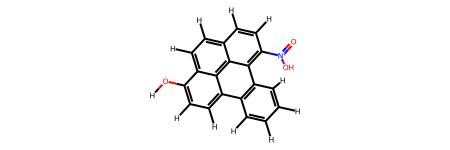

In [33]:
# Good examples: (from original raw dataset)
# Mutag: 3898 (GNNExplainer example), 1093
# Non-mutag: 2663, 944, 3705, 1089
dataset_idx = 3898
qry_ans = whole_dataset[dataset_idx]

# dataset_idx = qry_ans[2] 
data = dataset[dataset_idx]

test_features = qry_ans[0].unsqueeze(0)  # (1, N_QUERIES)
test_labels = qry_ans[1].unsqueeze(0)  # (1)
test_sample_id = qry_ans[2].unsqueeze(0)  # (1)

test_features = test_features.to(device)
test_labels = test_labels.to(device)

print(test_features.shape)
print(test_labels.shape)
print(test_sample_id)

G = mutagenicity_utils.raw_to_nx(data)
mol = mutagenicity_utils.nx_to_rdkit(G)
mol

In [34]:
from rdkit import Chem
smiles = Chem.MolToSmiles(mol)
print(smiles)

[H]Oc1c([H])c([H])c2c3c([H])c([H])c([H])c([H])c3c3c([N+](=O)O)c([H])c([H])c4c([H])c([H])c1c2c43


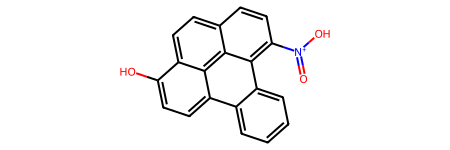

In [35]:
mol2 = Chem.MolFromSmiles(smiles)
mol2

Set evaluation parameters.

In [12]:
N_QUERIES = 403
max_queries_test = train_params['max_queries_test']
THRESHOLD = train_params['threshold']

In [13]:
params = {
    'test_features': test_features,
    'querier': querier,
    'classifier': classifier,
    'n_queries': N_QUERIES,
    'max_queries_test': max_queries_test,
}
logits, queries = evaluate(**params)

In [14]:
# prediction using all queries (last query?)
test_pred_max = logits[:, -1, :].argmax(dim=1).float()
# test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()

# compute number of queries needed for prediction
qry_need = ops.compute_queries_needed(logits, threshold=THRESHOLD)

# prediction using IP
test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)
# test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()

print(test_pred_max)
print(test_pred_ip)

tensor([0.], device='cuda:0')
tensor([0], device='cuda:0')


In [15]:
# Get query answer pairs that querier produced, but in natural language that 
q_ans_pairs = []
for q in queries[0]:
    q_idx = torch.argmax(q).item()
    q_name = mutagenicity_utils.get_query_name_list()[q_idx]
    q_ans = qry_ans[0][q_idx].item()
    q_ans_pairs.append((q_name, q_ans))

q_ans_pairs

[('NH1=0', 1),
 ('bicyclic=0', -1),
 ('benzene=0', 1),
 ('COO2=0', 1),
 ('halogen=0', -1),
 ('C_O_noCOO=0', -1),
 ('NH0=0', -1),
 ('nitroso=0', 1),
 ('ArN=0', -1),
 ('NH0=1', 1),
 ('benzene=1', -1),
 ('pyridine=0', -1),
 ('bicyclic=1', -1),
 ('epoxide=0', 1),
 ('aniline=0', -1),
 ('ether=0', 1),
 ('bicyclic=3', 1),
 ('Ar_OH=0', 1),
 ('alkyl_halide=0', 1),
 ('para_hydroxylation=0', 1)]

In [16]:
# Get the functional groups and their counts present in the sample, in natural language
all_frag_counts = mutagenicity_utils.onehot_to_interpretable_dict(qry_ans[0])
frag_count_list = []
for frag, count in all_frag_counts.items():
    if count > 0:
        frag_count_list.append((frag, count))

frag_count_list

[('ArN', 1),
 ('Ar_N', 1),
 ('C_O', 1),
 ('C_O_noCOO', 1),
 ('NH0', 1),
 ('NH2', 1),
 ('aniline', 1),
 ('bicyclic', 3),
 ('halogen', 1),
 ('pyridine', 1)]

Posterior Probability Heatmap (like Figure 3b and 3c in paper)

In [17]:
logits

tensor([[[ 0.1378, -0.1473],
         [ 0.3736, -0.3764],
         [-0.5652,  0.5752],
         [-0.4021,  0.4050],
         [-0.1441,  0.1487],
         [ 0.3946, -0.3669],
         [ 0.7023, -0.6728],
         [-0.0296,  0.0493],
         [ 0.1167, -0.1040],
         [ 0.5868, -0.5529],
         [ 0.5825, -0.5268],
         [ 0.9859, -0.9430],
         [ 1.2431, -1.2057],
         [ 1.5900, -1.5611],
         [ 2.0803, -2.0414],
         [ 1.9190, -1.8678],
         [ 2.7947, -2.7283],
         [ 3.0693, -3.0060],
         [ 2.8355, -2.7706],
         [ 2.6459, -2.5702]]], device='cuda:0')

In [18]:
probs = F.softmax(logits, dim=2)
probs

tensor([[[0.5708, 0.4292],
         [0.6792, 0.3208],
         [0.2422, 0.7578],
         [0.3085, 0.6915],
         [0.4273, 0.5727],
         [0.6817, 0.3183],
         [0.7982, 0.2018],
         [0.4803, 0.5197],
         [0.5550, 0.4450],
         [0.7576, 0.2424],
         [0.7520, 0.2480],
         [0.8731, 0.1269],
         [0.9205, 0.0795],
         [0.9589, 0.0411],
         [0.9840, 0.0160],
         [0.9778, 0.0222],
         [0.9960, 0.0040],
         [0.9977, 0.0023],
         [0.9963, 0.0037],
         [0.9946, 0.0054]]], device='cuda:0')

In [19]:
queries[0][0:qry_need.item(), :].shape

torch.Size([12, 403])

In [20]:
test_features[0].shape

torch.Size([403])

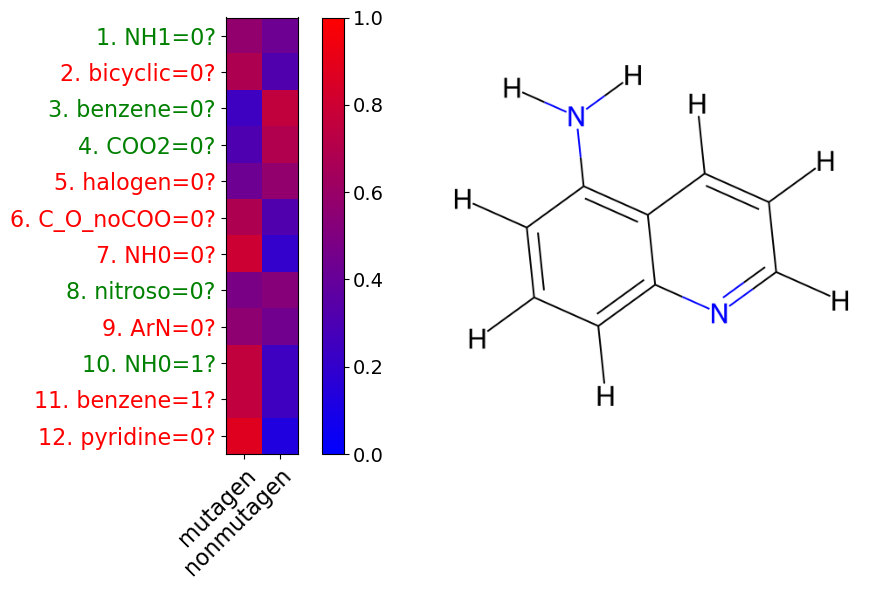

In [21]:
import matplotlib.pyplot as plt
q_chain_len = qry_need.item()
params = {
    'probs': probs[0][0:q_chain_len],
    'queries': queries[0][0:q_chain_len], 
    'answers': test_features[0], 
    'y_true': data.y.item(),
    'y_pred_max': test_pred_max.item(),
    'y_pred_ip': test_pred_ip.item(),
    'qry_need': q_chain_len,
    'threshold': THRESHOLD,
    'sample_id': test_sample_id.item(),
    'mol': mol,
    'no_title_no_funcgroups': True
}
fig, ax = mutagenicity_utils.create_posterior_prob_heatmap(**params);

fig_name = f'heatmap_mutag_id={dataset_idx}_{saved_name}-ep{epoch}_for_paper'
plt.savefig(f'./experiments/{fig_name}.pdf', bbox_inches='tight')  # Vector image for paper

Sanity Check: Evaluate on entire test set and see if test accuracy is same as that during train/test procedure (To make sure I'm using the same test set)

In [105]:
epoch_test_qry_need = []
epoch_test_acc_max = 0
epoch_test_acc_ip = 0
for test_features, test_labels, _ in tqdm(testloader):
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)

    params = {
        'test_features': test_features,
        'querier': querier,
        'classifier': classifier,
        'n_queries': N_QUERIES,
        'max_queries_test': max_queries_test,
    }
    logits, queries = evaluate(**params)

    # accuracy using all queries
    test_pred_max = logits[:, -1, :].argmax(dim=1).float()
    test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()
    epoch_test_acc_max += test_acc_max

    # compute number of queries needed for prediction
    qry_need = ops.compute_queries_needed(logits, threshold=THRESHOLD)
    epoch_test_qry_need.append(qry_need)

    # accuracy using IP
    test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)
    test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()
    epoch_test_acc_ip += test_acc_ip
epoch_test_acc_max = epoch_test_acc_max / len(testset)
epoch_test_acc_ip = epoch_test_acc_ip / len(testset)

# mean and std of queries needed
epoch_test_qry_need = torch.hstack(epoch_test_qry_need).float()
qry_need_avg = epoch_test_qry_need.mean()
qry_need_std = epoch_test_qry_need.std()

100%|██████████| 4/4 [00:00<00:00, 12.45it/s]


In [106]:
print(epoch_test_acc_max)
print(epoch_test_acc_ip)
print(qry_need_avg)
print(qry_need_std)

tensor(0.7760)
tensor(0.7667)
tensor(11.0046)
tensor(6.4212)


# Fixed Query Budget vs Test Accuracy Plot

In [26]:
max_query_budget = train_params['max_queries']
test_accs = [] 
TESTSET_SIZE = len(testset)
for max_queries_test in tqdm(range(1, max_query_budget+1)):
    epoch_test_acc_max = 0
    for test_features, test_labels, _ in tqdm(testloader):
        test_features = test_features.to(device)
        test_labels = test_labels.to(device)

        params = {
            'test_features': test_features,
            'querier': querier,
            'classifier': classifier,
            'n_queries': N_QUERIES,
            'max_queries_test': max_queries_test,
        }
        logits, queries = evaluate(**params)

        # accuracy using all queries
        test_pred_max = logits[:, -1, :].argmax(dim=1).float()
        test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()
        epoch_test_acc_max += test_acc_max
    epoch_test_acc_max = epoch_test_acc_max / TESTSET_SIZE
    test_accs.append(epoch_test_acc_max.item())

# Save numpy array
test_accs = np.array(test_accs)
np.save('./experiments/fb_test_accs.npy', test_accs)

100%|██████████| 403/403 [03:21<00:00,  2.00it/s]


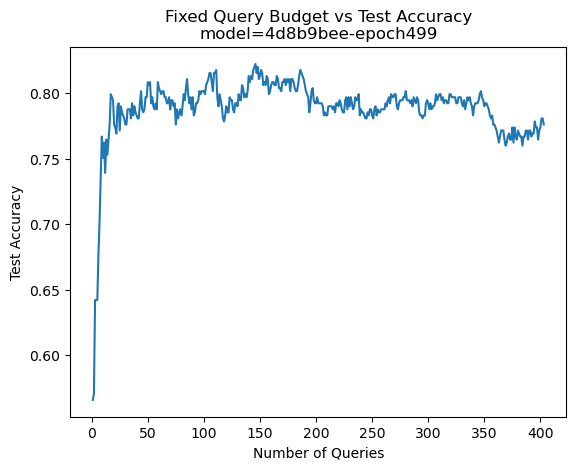

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = range(1, max_query_budget+1)
y = test_accs

# ax.set_xticks(np.arange(max_query_budget+1))
ax.set_xticks(range(0, max_query_budget+1, 50))
ax.plot(x, y)

ax.set_title(f'Fixed Query Budget vs Test Accuracy\nmodel={saved_name}-epoch{epoch}')
ax.set_xlabel('Number of Queries')
ax.set_ylabel('Test Accuracy')

# fig_name = f'fixed_qry_budget_vs_test_acc_{saved_name}-ep{epoch}_for_paper.png'
# plt.savefig(f'./experiments/{fig_name}', bbox_inches='tight')
#plt.savefig(f'./experiments/{fig_name}.pdf', bbox_inches='tight')  # Vector image for paper

plt.show()

# Avg Num Queries Needed Given Threshold vs Test Accuracy 

In [31]:
threshold_list = np.arange(0.5, 1, 0.025)
test_accs_ip = []
qry_need_nums = []
for threshold in tqdm(threshold_list):
    epoch_test_acc_ip = 0
    epoch_test_qry_need = []
    for test_features, test_labels, _ in tqdm(testloader):
        test_features = test_features.to(device)
        test_labels = test_labels.to(device)

        params = {
            'test_features': test_features,
            'querier': querier,
            'classifier': classifier,
            'n_queries': N_QUERIES,
            'max_queries_test': N_QUERIES,
        }
        logits, queries = evaluate(**params)

        # compute number of queries needed for prediction
        qry_need = ops.compute_queries_needed(logits, threshold=threshold)
        epoch_test_qry_need.append(qry_need)

        # accuracy using IP
        test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)
        test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()
        epoch_test_acc_ip += test_acc_ip

    # overall test accuracy    
    epoch_test_acc_ip = epoch_test_acc_ip / TESTSET_SIZE
    test_accs_ip.append(epoch_test_acc_ip.item())

    # mean and std of queries needed
    epoch_test_qry_need = torch.hstack(epoch_test_qry_need).float()
    qry_need_nums.append(epoch_test_qry_need)

100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


In [49]:
# qry_need_nums = qry_need_nums.cpu()
qry_need_nums_np = [n.cpu().numpy() for n in qry_need_nums]
np.save('./experiments/qry_need_nums.npy', qry_need_nums_np)

In [50]:
qry_need_avgs = [qry_need.mean().item() for qry_need in qry_need_nums]
qry_need_stds = [qry_need.std().item() for qry_need in qry_need_nums]

# print(qry_need_avgs)
# print(qry_need_stds)

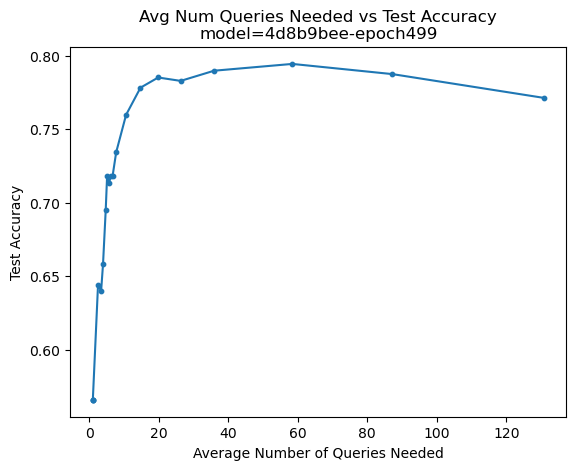

In [61]:
fig, ax = plt.subplots()

x = qry_need_avgs
y = test_accs_ip

# ax.set_xticks()
ax.plot(x, y)
ax.scatter(x, y, s=10)

ax.set_title(f'Avg Num Queries Needed vs Test Accuracy\nmodel={saved_name}-epoch{epoch}')
ax.set_xlabel('Average Number of Queries Needed')
ax.set_ylabel('Test Accuracy')

# Add threshold value to plot
# for i, threshold in enumerate(threshold_list):
#     ax.annotate(round(threshold, 3), (x[i], y[i]), size=8)

fig_name = f'avg_n_qry_need_vs_test_acc_{saved_name}-ep{epoch}_for_paper.png'
# plt.savefig(f'./experiments/{fig_name}')
# plt.savefig(f'./experiments/{fig_name}.pdf', bbox_inches='tight')  # Vector image for paper

plt.show()

# Produce all Heatmaps using IP

In [15]:
### EVALUATE ON TESTSET ###

N_QUERIES = 403
THRESHOLD = 0.85  # manually set to desired
max_queries_test = 30

epoch_test_acc_max = 0
epoch_test_acc_ip = 0

DATASET_SIZE = len(testset)

logits_list, queries_list, test_pred_max_list, test_pred_ip_list, qry_need_list = [], [], [], [], []
for test_features, test_labels, test_ids in tqdm(testloader):
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)
    test_ids = test_ids.to(device)

    params = {
            'test_features': test_features,
            'querier': querier,
            'classifier': classifier,
            'n_queries': N_QUERIES,
            'max_queries_test': max_queries_test,
        }
    logits, queries = evaluate(**params)  # (bs, max_queries_test, 2), (bs, max_queries_test, n_queries)
    logits_list.append(logits)
    queries_list.append(queries)
    
    # Use last query in chain for pred
    test_pred_max = logits[:, -1, :].argmax(dim=1).float()  # (bs)
    test_pred_max_list.append(test_pred_max)
    test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()
    epoch_test_acc_max += test_acc_max

    # Use IP for pred
    qry_need = ops.compute_queries_needed(logits, threshold=THRESHOLD)  # (bs)
    qry_need_list.append(qry_need)
    test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)  # (bs)
    test_pred_ip_list.append(test_pred_ip)
    test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()
    epoch_test_acc_ip += test_acc_ip

# Concatenate list of tensors
logits = torch.cat(logits_list, dim=0)
queries = torch.cat(queries_list, dim=0)
test_pred_max = torch.cat(test_pred_max_list, dim=0)
test_pred_ip = torch.cat(test_pred_ip_list, dim=0)
qry_need = torch.cat(qry_need_list, dim=0)

# Convert logits to probabilities
probs = F.softmax(logits, dim=2)

# Accuracies
epoch_test_acc_max = epoch_test_acc_max / DATASET_SIZE
epoch_test_acc_ip = epoch_test_acc_ip / DATASET_SIZE

# mean and std of queries needed
epoch_test_qry_need = qry_need.float()
qry_need_avg = epoch_test_qry_need.mean()
qry_need_std = epoch_test_qry_need.std()

print(f'test_acc_max: {test_acc_max}')
print(f'test_acc_ip: {test_acc_ip}')
print(f'qry_need_avg: {qry_need_avg}')
print(f'qry_need_std: {qry_need_std}')

100%|██████████| 4/4 [00:00<00:00,  9.13it/s]

test_acc_max: 40.0
test_acc_ip: 38.0
qry_need_avg: 13.270207405090332
qry_need_std: 9.943519592285156


In [16]:
# Split into TP, FP, TN, FN using IP pred
t_mutag, f_mutag, t_nonmutag, f_nonmutag = [], [], [], []
for i, data in enumerate(testset):
    y_pred = mutagenicity_utils.get_graph_label_mapping()[test_pred_ip[i].item()]
    y_true = mutagenicity_utils.get_graph_label_mapping()[data[1].item()]
    testset_idx = i
    if (y_pred == 'mutagen') and (y_true == 'mutagen'):
        t_mutag.append(testset_idx)
    elif (y_pred == 'mutagen') and (y_true == 'nonmutagen'):
        f_mutag.append(testset_idx)
    elif (y_pred == 'nonmutagen') and (y_true == 'nonmutagen'):
        t_nonmutag.append(testset_idx)
    elif (y_pred == 'nonmutagen') and (y_true == 'mutagen'):
        f_nonmutag.append(testset_idx)
    else:
        raise Exception('Invalid y_pred or y_true.')
    
print(f't_mutag: {len(t_mutag)}')
print(f'f_mutag: {len(f_mutag)}')
print(f't_nonmutag: {len(t_nonmutag)}')
print(f'f_nonmutag: {len(f_nonmutag)}')

t_mutag: 208
f_mutag: 62
t_nonmutag: 126
f_nonmutag: 37


## Figures for TP, FP, TN, FN

In [17]:
# Get query answer pairs that querier produced, but in natural language that 
q_ans_pairs = []
for q in queries[0]:
    q_idx = torch.argmax(q).item()
    q_name = mutagenicity_utils.get_query_name_list()[q_idx]
    q_ans = qry_ans[0][q_idx].item()
    q_ans_pairs.append((q_name, q_ans))

NameError: name 'qry_ans' is not defined

In [39]:
# Get the functional groups and their counts present in the sample, in natural language
all_frag_counts = mutagenicity_utils.onehot_to_interpretable_dict(qry_ans[0])
frag_count_list = []
for frag, count in all_frag_counts.items():
    if count > 0:
        frag_count_list.append((frag, count))
frag_count_list

NameError: name 'qry_ans' is not defined

In [ ]:
### CREATE VISUALIZATION ###
conf_matrix_list = [f_mutag] # [t_mutag, f_mutag, t_nonmutag, f_nonmutag]
conf_matrix_names = ['f_mutag']  # ['t_mutag', 'f_mutag', 't_nonmutag', 'f_nonmutag']
for idx_list, folder_name in tqdm(zip(conf_matrix_list, conf_matrix_names)):
    for idx in idx_list:
        test_features = testset[idx][0]
        y_true = testset[idx][1].item()
        dataset_id = testset[idx][2]
        data = dataset[dataset_id]
        G = mutagenicity_utils.raw_to_nx(data)
        mol = mutagenicity_utils.nx_to_rdkit(G)
        
        params = {
            'probs': probs[idx],
            'queries': queries[idx], 
            'answers': test_features, 
            'y_true': y_true,
            'y_pred_max': test_pred_max[idx].item(),
            'y_pred_ip': test_pred_ip[idx].item(),
            'qry_need': qry_need[idx].item(),
            'threshold': THRESHOLD,
            'sample_id': dataset_id,
            'mol': mol
        }
        fig, ax = mutagenicity_utils.create_posterior_prob_heatmap(**params);

NameError: name 'f_mutag' is not defined

## Mutagenic Molecules with Specific Functional Group(s)

In [11]:
THRESHOLD = 0.8

In [13]:
# Search for mutagenic molecules in testset that have benzene functional group present,
# and were predicted to be mutagenic, and benzene appears in IP query chain
key_func_groups = ['benzene']
saved = []
idx_in_q_chain = []
for idx in tqdm(range(len(testset))):  # only look at molecules predicted to be mutagenic
    answers = testset[idx][0]
    frag_count_dict = mutagenicity_utils.onehot_to_interpretable_dict(answers)
    
    for func_group in key_func_groups:
        if (frag_count_dict[func_group] > 0):  # Molecule has key functional groups present
            q_chain = queries[idx]
            q_chain_ip = q_chain[0:qry_need[idx]]

            for j in range(len(q_chain_ip)):
                qry = q_chain_ip[j]
                qry_name = mutagenicity_utils.onehot_to_query_name(qry)
                qry_func_group, count = qry_name.split('=')  # Keep only func group name, no ""=count"
                if (int(count) > 0) and (func_group == qry_func_group):  # query chain asks if desired func group has count > 0
                    saved.append(idx)
                    idx_in_q_chain.append(j)
                    break

  0%|          | 1/433 [00:00<00:02, 183.74it/s]


NameError: name 'queries' is not defined

In [113]:
len(saved)

534

In [12]:
### Create visualization for specific samples ###
import random
idx =  random.randint(0, len(testset))
print(f'testset_idx={idx}')
# for idx in saved[0:10]:
test_features = testset[idx][0]
y_true = testset[idx][1].item()
dataset_id = testset[idx][2]
data = dataset[dataset_id]
G = mutagenicity_utils.raw_to_nx(data)
mol = mutagenicity_utils.nx_to_rdkit(G)
q_chain_len = qry_need[idx].item()
params = {
    'probs': probs[idx][0:q_chain_len],
    'queries': queries[idx][0:q_chain_len], 
    'answers': test_features, 
    'y_true': y_true,
    'y_pred_max': test_pred_max[idx].item(),
    'y_pred_ip': test_pred_ip[idx].item(),
    'qry_need': q_chain_len,
    'threshold': THRESHOLD,
    'sample_id': dataset_id,
    'mol': mol
}
fig, ax = mutagenicity_utils.create_posterior_prob_heatmap(**params);

# fig.savefig('./experiments')

testset_idx=301


NameError: name 'qry_need' is not defined

# GNNExplainer Example Explanations

In [77]:
# Search for the example molecule in their paper
saved = []
ids = []
for idx, data in enumerate(dataset):
    C_count = 20
    H_count = 11
    O_count = 3
    N_count = 1
    atoms = data.atom
    # and (len(atoms) == C_count+H_count+O_count+N_count)
    if (atoms.count('C') == C_count) and (atoms.count('H') == H_count) and (atoms.count('O') == O_count) and (atoms.count('N') == N_count):
        saved.append(data)
        ids.append(idx)

In [78]:
saved

[Data(edge_index=[2, 78], x=[35, 14], edge_attr=[78, 3], y=[1], atom=[35], bonds=[78], mutagenicity='mutagen', num_undirected_edges=39),
 Data(edge_index=[2, 80], x=[35, 14], edge_attr=[80, 3], y=[1], atom=[35], bonds=[80], mutagenicity='mutagen', num_undirected_edges=40),
 Data(edge_index=[2, 78], x=[35, 14], edge_attr=[78, 3], y=[1], atom=[35], bonds=[78], mutagenicity='mutagen', num_undirected_edges=39)]

In [65]:
data.num_nodes

29

In [80]:
ids[2]

3898

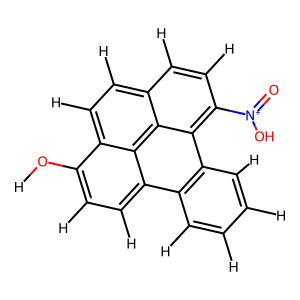

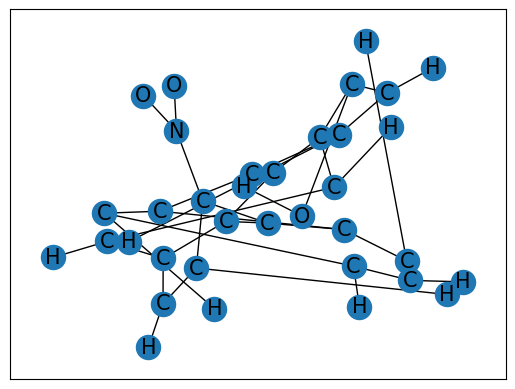

In [75]:
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import networkx as nx

# for data in saved:
data = saved[2]

custom_labels = {}
for i in range(data.num_nodes):
    custom_labels[i] = data.atom[i]

pos = nx.spring_layout(G)  # Position nodes using a layout
G = mutagenicity_utils.raw_to_nx(data)
nx.draw_networkx(G, pos, with_labels=False)
nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=15, font_color='black')

mol = mutagenicity_utils.nx_to_rdkit(G)
img = Draw.MolToImage(mol)
img